In [1]:
# Connect With Drive
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

# %cd to api key
%cd /content/drive/MyDrive/NAACL 2024 /Scientometrics
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NAACL 2024 /Scientometrics
'1. Global Health PMIDs Extraction.ipynb'
 Data_extraction.ipynb
 EDA.ipynb
 gender-api-output.csv
 HICs_preprocessed_global_health_papers_2018_2023.csv
'List of economies.csv'
 LMICs_preprocessed_global_health_papers_2018_2023.csv
 papers_2021_2024.csv
 Papers_Info.csv
 Papers_Info_raw.csv
 Preprocessed_papers_full.csv
 Preprocessing.ipynb


In [2]:
!pip install pycountry
!pip install pycountry_convert

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import pycountry
import pycountry_convert as pc

# Dictionary to map problematic country names to their ISO alpha-3 codes
country_name_corrections = {
    'Democratic Republic of the Congo': 'COD',
    'Turkey': 'TUR',
    'Russia': 'RUS',
    'Ivory Coast': 'CIV',
    'Palestinian Territory': 'PSE',
    'Reunion': 'REU',
    'Timor Leste': 'TLS',
    'Vatican': 'VAT',
    'Brunei': 'BRN',
    'Saint Helena': 'SHN',
    'Micronesia': 'FSM',
    'Sint Maarten': 'SXM'
}

# Function to convert country names to ISO alpha-3 country codes
def country_to_alpha_3(country_name):
    if country_name in country_name_corrections:
        return country_name_corrections[country_name]
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        if country_name is not np.nan:
            print(f'Error: {country_name} not found in pycountry')
        return np.nan

# Function to extract the first name from a full name
def extract_first_name(full_name):
    try:
        names = full_name.split()
        if names[0].endswith(','):
            if len(names) > 1 and not names[1].endswith('.'):
                return names[1]
            elif len(names) > 2:
                return names[2]
        elif names[0].endswith('.'):
            if len(names) > 1 and not names[1].endswith('.'):
                return names[1]
            elif len(names) > 2:
                return names[2]
        return names[0]
    except:
        return np.nan

# Function to convert alpha-3 to alpha-2 country code
def alpha3_to_alpha2(alpha_3):
    try:
        return pycountry.countries.get(alpha_3=alpha_3).alpha_2
    except:
        return None

# Function to get continent from alpha-3 country code
def get_continent(alpha_3):
    alpha_2 = alpha3_to_alpha2(alpha_3)
    if alpha_2:
        try:
            continent_code = pc.country_alpha2_to_continent_code(alpha_2)
            continent_name = pc.convert_continent_code_to_continent_name(continent_code)
            return continent_name
        except:
            return None
    return None

### Read data and get the name of sex extraction

In [4]:
df = pd.read_csv('Preprocessed_papers_full.csv')
# Get full name from 'first_name' and'last_name'
df['full_name'] = df['first_name'] + ' ' + df['last_name']

# Apply the extraction function
df['extracted_first_name'] = df['full_name'].apply(extract_first_name)
# remove the rows with missing values in the 'extracted_first_name' column
df = df.dropna(subset=['extracted_first_name'])

df.head()

,authors,date,doi,id,journal,linkout,source_title,title,year,funder_countries,...,funder_name,funder_country,funder_country_code,journal_title,author_position,last_author_position,is_first_author,is_last_author,full_name,extracted_first_name
0,"{'affiliations': [{'city': 'Ann Arbor', 'city_...",2024-06-07,10.2196/58370,pub.1172744332,"{'id': 'jour.1053709', 'title': 'JMIR Medical ...",http://dx.doi.org/10.2196/58370,"{'id': 'jour.1053709', 'title': 'JMIR Medical ...",Authors' Reply: A Use Case for Generative AI i...,2024,NaN,...,NaN,NaN,NaN,JMIR Medical Education,1.0,2.0,True,False,Tricia Pendergrast,Tricia
1,"{'affiliations': [{'city': 'Evanston', 'city_i...",2024-06-07,10.2196/58370,pub.1172744332,"{'id': 'jour.1053709', 'title': 'JMIR Medical ...",http://dx.doi.org/10.2196/58370,"{'id': 'jour.1053709', 'title': 'JMIR Medical ...",Authors' Reply: A Use Case for Generative AI i...,2024,NaN,...,NaN,NaN,NaN,JMIR Medical Education,2.0,2.0,False,True,Zachary Chalmers,Zachary
2,"{'affiliations': [{'city': 'Boston', 'city_id'...",2024-06-11,10.1542/peds.2023-065573,pub.1172744193,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",NaN,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",Performance of ChatGPT and Google Translate fo...,2024,NaN,...,NaN,NaN,NaN,Pediatrics,1.0,9.0,True,False,Ryan C L Brewster,Ryan
3,"{'affiliations': [{'city': 'Boston', 'city_id'...",2024-06-11,10.1542/peds.2023-065573,pub.1172744193,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",NaN,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",Performance of ChatGPT and Google Translate fo...,2024,NaN,...,NaN,NaN,NaN,Pediatrics,2.0,9.0,False,False,Priscilla Gonzalez,Priscilla
4,"{'affiliations': [{'city': None, 'city_id': No...",2024-06-11,10.1542/peds.2023-065573,pub.1172744193,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",NaN,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",Performance of ChatGPT and Google Translate fo...,2024,NaN,...,NaN,NaN,NaN,Pediatrics,3.0,9.0,False,False,Rohan Khazanchi,Rohan


### Get the sex of that author based on the name and country

In [5]:
gender_ref = pd.read_csv('gender-api-output.csv', index_col=0)

# Function to convert 2-digit country codes to 3-digit country codes
def convert_alpha2_to_alpha3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return code

# Apply the conversion
gender_ref['country_code'] = gender_ref['country_code'].apply(convert_alpha2_to_alpha3)

In [6]:
# Merge with gender_ref to get the gender
df = pd.merge(df, gender_ref, how='left', left_on=['extracted_first_name', 'first_country_code'], right_on=['name_standard', 'country_code'])
df.rename(columns={'ga_gender': 'gender'}, inplace=True)

df

,authors,date,doi,id,journal,linkout,source_title,title,year,funder_countries,...,is_last_author,full_name,extracted_first_name,name_standard,country_code,name_selection,ga_first_name,gender,ga_accuracy,ga_samples
0,"{'affiliations': [{'city': 'Ann Arbor', 'city_...",2024-06-07,10.2196/58370,pub.1172744332,"{'id': 'jour.1053709', 'title': 'JMIR Medical ...",http://dx.doi.org/10.2196/58370,"{'id': 'jour.1053709', 'title': 'JMIR Medical ...",Authors' Reply: A Use Case for Generative AI i...,2024,NaN,...,False,Tricia Pendergrast,Tricia,Tricia,USA,first,Tricia,female,99.0,2109.0
1,"{'affiliations': [{'city': 'Evanston', 'city_i...",2024-06-07,10.2196/58370,pub.1172744332,"{'id': 'jour.1053709', 'title': 'JMIR Medical ...",http://dx.doi.org/10.2196/58370,"{'id': 'jour.1053709', 'title': 'JMIR Medical ...",Authors' Reply: A Use Case for Generative AI i...,2024,NaN,...,True,Zachary Chalmers,Zachary,Zachary,USA,first,Zachary,male,100.0,6186.0
2,"{'affiliations': [{'city': 'Boston', 'city_id'...",2024-06-11,10.1542/peds.2023-065573,pub.1172744193,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",NaN,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",Performance of ChatGPT and Google Translate fo...,2024,NaN,...,False,Ryan C L Brewster,Ryan,Ryan,USA,first,Ryan,male,99.0,35179.0
3,"{'affiliations': [{'city': 'Boston', 'city_id'...",2024-06-11,10.1542/peds.2023-065573,pub.1172744193,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",NaN,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",Performance of ChatGPT and Google Translate fo...,2024,NaN,...,False,Ryan C L Brewster,Ryan,Ryan,USA,second,Ryan,male,99.0,35179.0
4,"{'affiliations': [{'city': 'Boston', 'city_id'...",2024-06-11,10.1542/peds.2023-065573,pub.1172744193,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",NaN,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",Performance of ChatGPT and Google Translate fo...,2024,NaN,...,False,Priscilla Gonzalez,Priscilla,Priscilla,USA,first,Priscilla,female,99.0,1894.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9117,"{'affiliations': [{'city': 'Stanford', 'city_i...",2020-12-05,10.1016/j.jbi.2020.103637,pub.1133106885,"{'id': 'jour.1429555', 'title': 'Journal of Bi...",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"{'id': 'jour.1429555', 'title': 'Journal of Bi...",Language models are an effective representatio...,2020,"[{'id': 'US', 'name': 'United States'}]",...,True,Nigam H Shah,Nigam,Nigam,USA,first,Nigam,male,100.0,5.0
9118,"{'affiliations': [{'city': 'Chicago', 'city_id...",2020-11-28,10.1016/j.jbi.2020.103626,pub.1132967688,"{'id': 'jour.1429555', 'title': 'Journal of Bi...",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"{'id': 'jour.1429555', 'title': 'Journal of Bi...",Pre-training phenotyping classifiers,2020,"[{'id': 'US', 'name': 'United States'}]",...,False,Dmitriy Dligach,Dmitriy,Dmitriy,USA,first,Dmitriy,male,100.0,206.0
9119,"{'affiliations': [{'city': 'Madison', 'city_id...",2020-11-28,10.1016/j.jbi.2020.103626,pub.1132967688,"{'id': 'jour.1429555', 'title': 'Journal of Bi...",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"{'id': 'jour.1429555', 'title': 'Journal of Bi...",Pre-training phenotyping classifiers,2020,"[{'id': 'US', 'name': 'United States'}]",...,False,Majid Afshar,Majid,Majid,USA,first,Majid,male,99.0,171.0
9120,"{'affiliations': [{'city': 'Boston', 'city_id'...",2020-11-28,10.1016/j.jbi.2020.103626,pub.1132967688,"{'id': 'jour.1429555', 'title': 'Journal of Bi...",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"{'id': 'jour.1429555', 'title': 'Journal of Bi...",Pre-training phenotyping classifiers,2020,"[{'id': 'US', 'name': 'United States'}]",...,True,Timothy Miller,Timothy,Timothy,USA,first,Timothy,male,100.0,9427.0


In [7]:
#import gender_guesser.detector as gender

#d = gender.Detector()

# Function to guess the gender
#def guess_gender(name):
#    try:
#        return d.get_gender(name)
#    except:
#        print(f'Error: {name}')
#        return np.nan

# Apply the function to the 'first_name' column
#df['gender'] = df['first_name'].apply(guess_gender)
# replace 'mostly_male' by 'male' and 'mostly_female' by 'female'
#df['gender'] = df['gender'].replace({'mostly_male':'male', 'mostly_female': 'female', 'andy': 'androgynous'})

### Classify countries by LMIC and HIC and continent

In [8]:
## Create sub-groups
wb_df = pd.read_csv('List of economies.csv', sep=';').drop(columns='Unnamed: 5')

# Classify countries into HICs and LMICs based on the identified groups
hic_country_codes = set(wb_df[wb_df['Income group'] == 'High income']['Code'])
lmic_country_codes = set(wb_df[wb_df['Income group'].isin(['Low income', 'Lower middle income', 'Upper middle income'])]['Code'])

# Check if any of the country codes in the row are in the given set
def is_in_country_list(row, country_set):
    return (
        row['first_country_code'] in country_set or
        row['second_country_code'] in country_set or
        row['third_country_code'] in country_set
    )

# create a new column in the DataFrame to classify the countries LMIC true or false. If any of the countries in the row is a LMIC, the row is classified as LMIC
df['LMIC'] = df.apply(is_in_country_list, country_set=lmic_country_codes, axis=1)
# create a new column in the DataFrame to classify the countries HIC true or false. If any of the countries in the row is a HIC, the row is classified as HIC
df['HIC'] = df.apply(is_in_country_list, country_set=hic_country_codes, axis=1)

In [9]:
# Adding continent columns
continents = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
for continent in continents:
    df[continent] = 0
    df[f'{continent}_LMIC'] = 0
    df[f'{continent}_HIC'] = 0

# Populate the continent columns
for continent in continents:
    df[continent] = df['first_country_code'].apply(lambda x: get_continent(x) == continent if x is not np.nan else False).astype(int)
    df[continent] = df[continent] | df['second_country_code'].apply(lambda x: get_continent(x) == continent if x is not np.nan else False).astype(int)
    df[continent] = df[continent] | df['third_country_code'].apply(lambda x: get_continent(x) == continent if x is not np.nan else False).astype(int)

    df[f'{continent}_LMIC'] = df.apply(
        lambda row: (get_continent(row['first_country_code']) == continent and row['first_country_code'] in lmic_country_codes) or
                    (get_continent(row['second_country_code']) == continent and row['second_country_code'] in lmic_country_codes) or
                    (get_continent(row['third_country_code']) == continent and row['third_country_code'] in lmic_country_codes), axis=1).astype(int)

    df[f'{continent}_HIC'] = df.apply(
        lambda row: (get_continent(row['first_country_code']) == continent and row['first_country_code'] in hic_country_codes) or
                    (get_continent(row['second_country_code']) == continent and row['second_country_code'] in hic_country_codes) or
                    (get_continent(row['third_country_code']) == continent and row['third_country_code'] in hic_country_codes), axis=1).astype(int)


In [10]:
continents = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
income_groups = ['HIC', 'LMIC']

def get_continent_and_income(country_code):
    continent = get_continent(country_code)
    if country_code in lmic_country_codes:
        return f"{continent}_LMIC"
    elif country_code in hic_country_codes:
        return f"{continent}_HIC"
    return None

for continent in continents:
    for income_group in income_groups:
        df[f'{continent}_{income_group}_funder'] = 0

# Populate the funder continent and income columns
for i, row in df.iterrows():
    if pd.notna(row['funder_country_code']):
        continent_income = get_continent_and_income(row['funder_country_code'])
        if continent_income:
            df.at[i, f'{continent_income}_funder'] = 1

In [11]:
df.head()

,authors,date,doi,id,journal,linkout,source_title,title,year,funder_countries,...,Asia_HIC_funder,Asia_LMIC_funder,Europe_HIC_funder,Europe_LMIC_funder,North America_HIC_funder,North America_LMIC_funder,Oceania_HIC_funder,Oceania_LMIC_funder,South America_HIC_funder,South America_LMIC_funder
0,"{'affiliations': [{'city': 'Ann Arbor', 'city_...",2024-06-07,10.2196/58370,pub.1172744332,"{'id': 'jour.1053709', 'title': 'JMIR Medical ...",http://dx.doi.org/10.2196/58370,"{'id': 'jour.1053709', 'title': 'JMIR Medical ...",Authors' Reply: A Use Case for Generative AI i...,2024,NaN,...,0,0,0,0,0,0,0,0,0,0
1,"{'affiliations': [{'city': 'Evanston', 'city_i...",2024-06-07,10.2196/58370,pub.1172744332,"{'id': 'jour.1053709', 'title': 'JMIR Medical ...",http://dx.doi.org/10.2196/58370,"{'id': 'jour.1053709', 'title': 'JMIR Medical ...",Authors' Reply: A Use Case for Generative AI i...,2024,NaN,...,0,0,0,0,0,0,0,0,0,0
2,"{'affiliations': [{'city': 'Boston', 'city_id'...",2024-06-11,10.1542/peds.2023-065573,pub.1172744193,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",NaN,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",Performance of ChatGPT and Google Translate fo...,2024,NaN,...,0,0,0,0,0,0,0,0,0,0
3,"{'affiliations': [{'city': 'Boston', 'city_id'...",2024-06-11,10.1542/peds.2023-065573,pub.1172744193,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",NaN,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",Performance of ChatGPT and Google Translate fo...,2024,NaN,...,0,0,0,0,0,0,0,0,0,0
4,"{'affiliations': [{'city': 'Boston', 'city_id'...",2024-06-11,10.1542/peds.2023-065573,pub.1172744193,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",NaN,"{'id': 'jour.1017874', 'title': 'Pediatrics'}",Performance of ChatGPT and Google Translate fo...,2024,NaN,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Filter the DataFrame for HIC and LMIC
hic_df = df[df.apply(is_in_country_list, country_set=hic_country_codes, axis=1)]
lmic_df = df[df.apply(is_in_country_list, country_set=lmic_country_codes, axis=1)]

hic_df.to_csv('HICs_preprocessed_global_health_papers_2018_2023.csv', index=False)
lmic_df.to_csv('LMICs_preprocessed_global_health_papers_2018_2023.csv', index=False)

# EDA

## Sex distribution

#### ALL

In [14]:
def plot_gender_distribution(df):
    # Function to calculate and plot proportions
    def plot_proportion(data, title):
        # Filter out missing values and unknowns
        data = data.dropna()
        data = data[data != 'unknown']

        # Calculate proportions
        proportions = data.value_counts(normalize=True)
        print(title)
        print(proportions)

        # Bar plot of the proportions
        sns.barplot(x=proportions.index, y=proportions.values, order=['male', 'female'])
        plt.title(title)
        plt.ylabel('Proportion')
        plt.xlabel('Gender')
        plt.show()

    # All authors
    plot_proportion(df['gender'], 'Gender distribution in the dataset')

    # First authors
    first_authors = df[df['is_first_author'] == True]['gender']
    plot_proportion(first_authors, 'Gender distribution of first authors in the dataset')

    # Last authors
    last_authors = df[df['is_last_author'] == True]['gender']
    plot_proportion(last_authors, 'Gender distribution of last authors in the dataset')

In [15]:
def plot_gender_distribution_absolute(df):
    # Function to calculate and plot absolute values
    def plot_counts(data, title):
        # Filter out missing values and unknowns
        data = data.dropna()
        data = data[data != 'unknown']

        # Calculate counts
        counts = data.value_counts()
        print(title)
        print(counts)

        # Bar plot of the counts
        sns.countplot(x=data, order=['male', 'female'])
        plt.title(title)
        plt.ylabel('Count')
        plt.xlabel('Gender')
        plt.show()

    # All authors
    plot_counts(df['gender'], 'Gender distribution in the dataset')

    # First authors
    first_authors = df[df['is_first_author'] == True]['gender']
    plot_counts(first_authors, 'Gender distribution of first authors in the dataset')

    # Last authors
    last_authors = df[df['is_last_author'] == True]['gender']
    plot_counts(last_authors, 'Gender distribution of last authors in the dataset')


Gender distribution in the dataset
gender
male      0.762889
female    0.237111
Name: proportion, dtype: float64


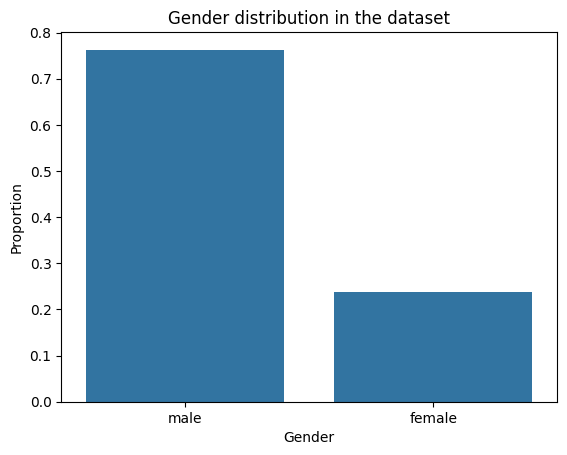

Gender distribution of first authors in the dataset
gender
male      0.796064
female    0.203936
Name: proportion, dtype: float64


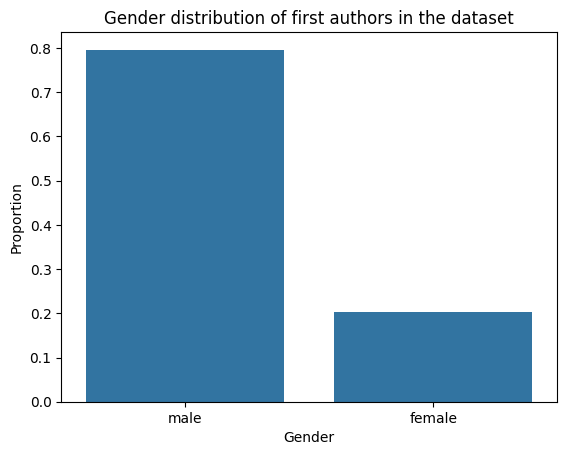

Gender distribution of last authors in the dataset
gender
male      0.833995
female    0.166005
Name: proportion, dtype: float64


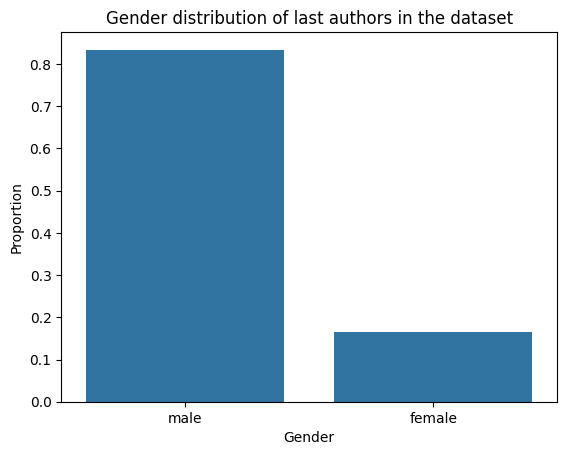

Gender distribution in the dataset
gender
male      5756
female    1789
Name: count, dtype: int64


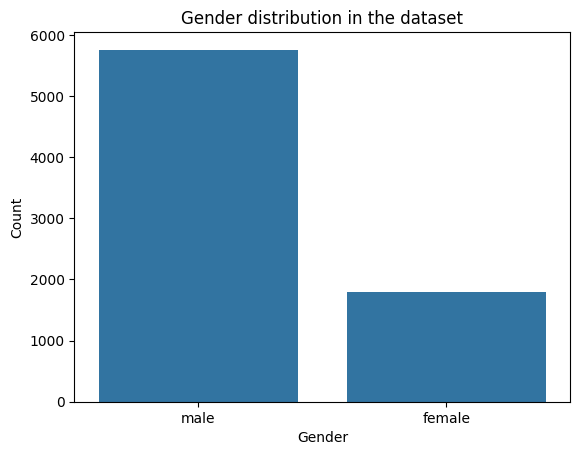

Gender distribution of first authors in the dataset
gender
male      890
female    228
Name: count, dtype: int64


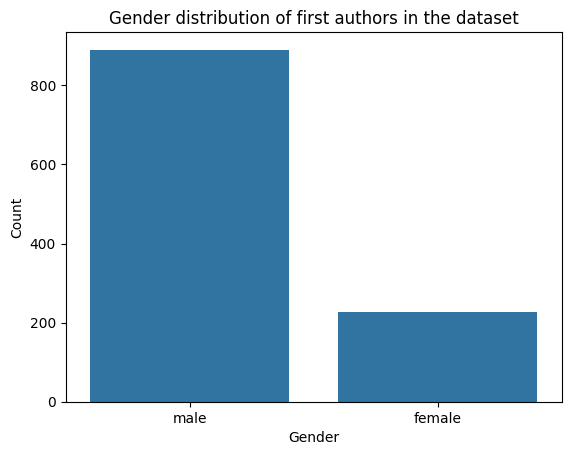

Gender distribution of last authors in the dataset
gender
male      1050
female     209
Name: count, dtype: int64


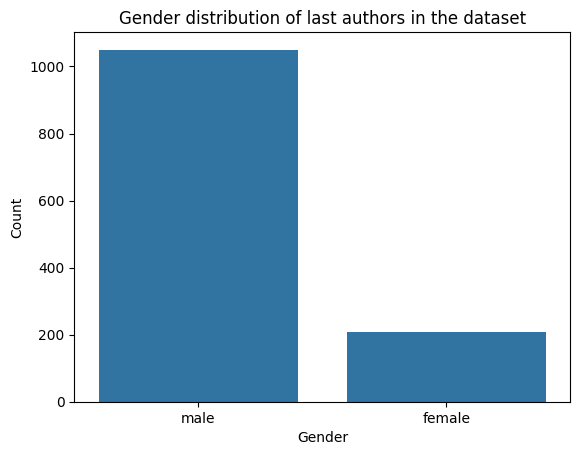

In [16]:
plot_gender_distribution(df)
plot_gender_distribution_absolute(df)

#### HICS

Gender distribution in the dataset
gender
male      0.765538
female    0.234462
Name: proportion, dtype: float64


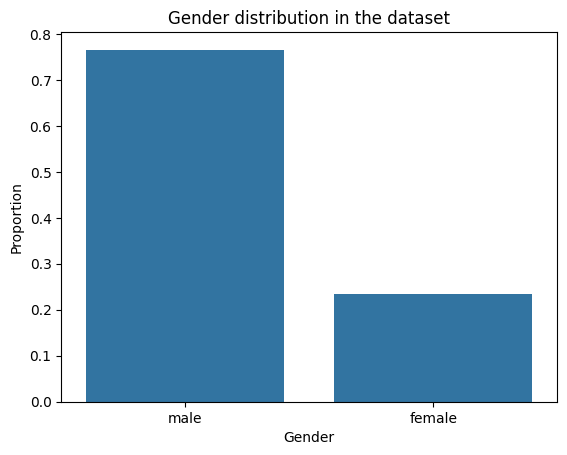

Gender distribution of first authors in the dataset
gender
male      0.793139
female    0.206861
Name: proportion, dtype: float64


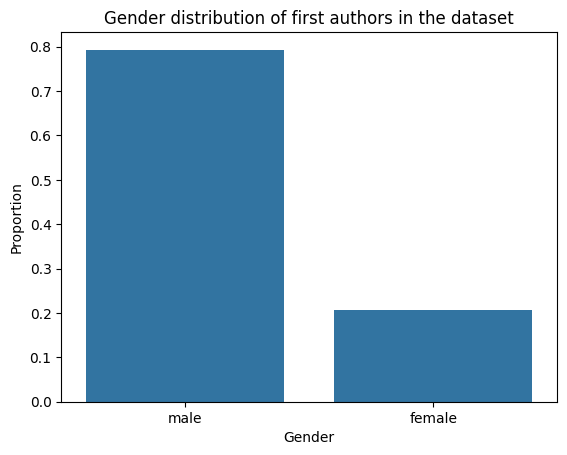

Gender distribution of last authors in the dataset
gender
male      0.843806
female    0.156194
Name: proportion, dtype: float64


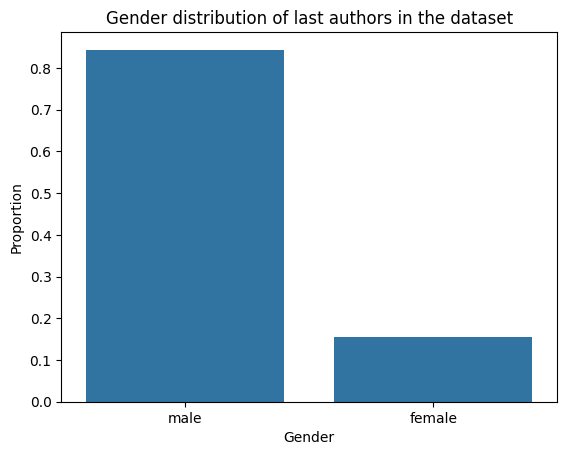

Gender distribution in the dataset
gender
male      5087
female    1558
Name: count, dtype: int64


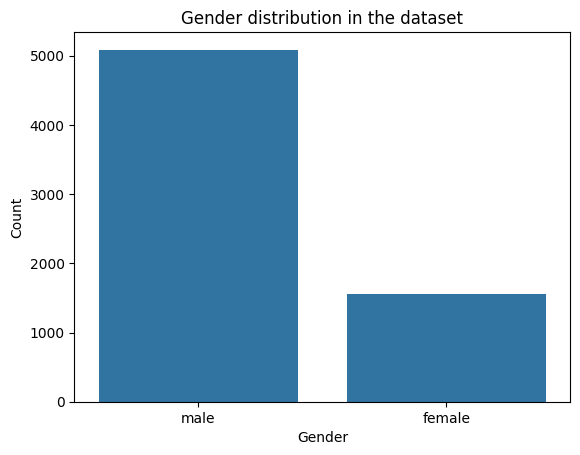

Gender distribution of first authors in the dataset
gender
male      763
female    199
Name: count, dtype: int64


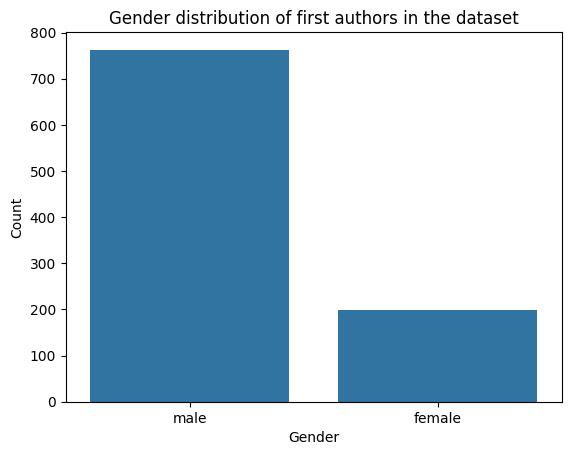

Gender distribution of last authors in the dataset
gender
male      940
female    174
Name: count, dtype: int64


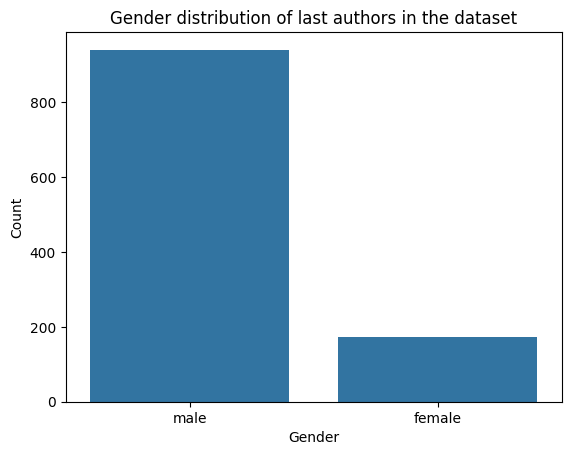

In [17]:
plot_gender_distribution(hic_df)
plot_gender_distribution_absolute(hic_df)

#### LMICs

Gender distribution in the dataset
gender
male      0.748652
female    0.251348
Name: proportion, dtype: float64


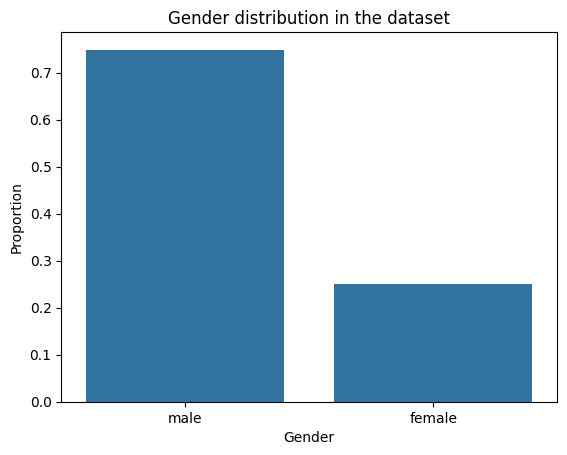

Gender distribution of first authors in the dataset
gender
male      0.814815
female    0.185185
Name: proportion, dtype: float64


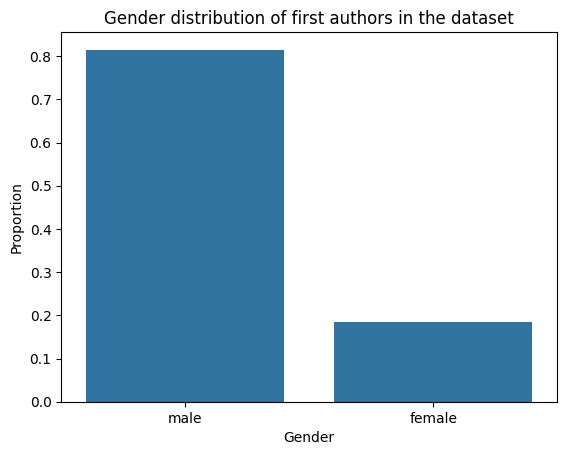

Gender distribution of last authors in the dataset
gender
male      0.766667
female    0.233333
Name: proportion, dtype: float64


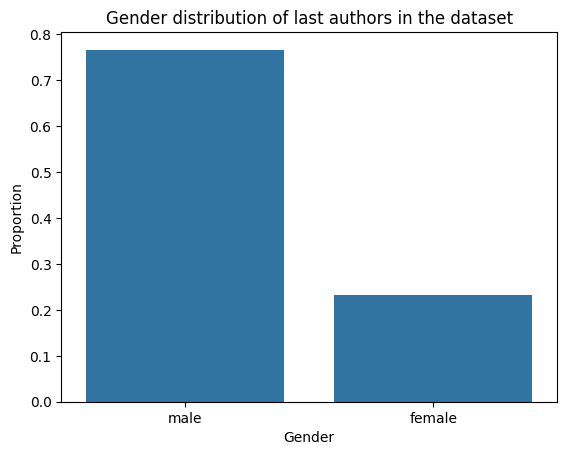

Gender distribution in the dataset
gender
male      694
female    233
Name: count, dtype: int64


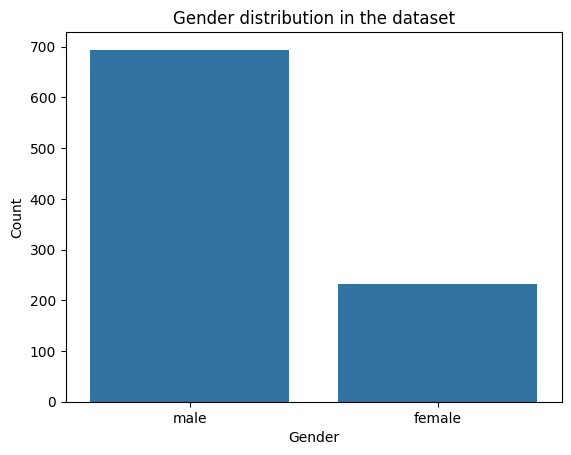

Gender distribution of first authors in the dataset
gender
male      132
female     30
Name: count, dtype: int64


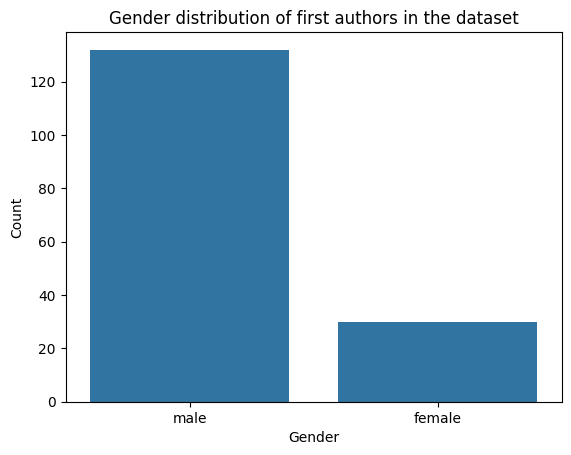

Gender distribution of last authors in the dataset
gender
male      115
female     35
Name: count, dtype: int64


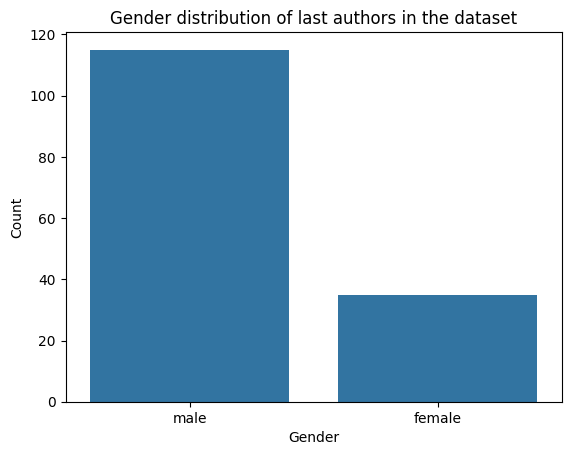

In [18]:
plot_gender_distribution(lmic_df)
plot_gender_distribution_absolute(lmic_df)

### TOP 15 Countries Per author per Journal

##### Only showing the top 15 countries per author per journals with more than 300 papers

In [19]:
def top_15_countries_per_journal_per_year(df, list_countries=None, n_papers=300):
    # Melt the dataframe to count countries from first_country, second_country, third_country
    countries_df = df.melt(id_vars=['journal_title', 'year', 'id'], value_vars=['first_country', 'second_country', 'third_country'],
                           var_name='country_type', value_name='country')
    country_codes_df = df.melt(id_vars=['journal_title', 'year', 'id'],
                            value_vars=['first_country_code', 'second_country_code', 'third_country_code'],
                            var_name='country_code_type', value_name='country_code')

    # Merge the two melted DataFrames on the index
    countries_df['country_code'] = country_codes_df['country_code']

    # Filter by list_countries if provided
    if list_countries:
        countries_df = countries_df[countries_df['country_code'].isin(list_countries)]


    # Group by journal, year, and country to count occurrences
    country_counts = countries_df.groupby(['journal_title', 'year', 'country']).size().reset_index(name='counts')

    # Generate plots per journal and then per year within each journal
    for journal in country_counts['journal_title'].unique():
        journal_data = country_counts[country_counts['journal_title'] == journal]

        # Filter out journals with fewer than n_papers
        unique_papers = countries_df[countries_df['journal_title'] == journal]['id'].nunique()
        if unique_papers < n_papers:
            #print(f'Journal {journal} has less than {n_papers} papers ({unique_papers}), so it will not be plotted.')
            continue

        # Sort values and get the top 15 countries per year within the journal
        top_15_per_year = journal_data.groupby(['year']).apply(lambda x: x.nlargest(15, 'counts')).reset_index(drop=True)

        # Plot the journal data for all years
        plt.figure(figsize=(14, 8))
        sns.barplot(data=top_15_per_year, x='year', y='counts', hue='country') #, order=top_15_per_year['country'].value_counts().index)
        plt.title(f'Top 15 Countries Published in {journal}')
        plt.xticks(rotation=90)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # Plot the journal data for all years (by country)
        plt.figure(figsize=(14, 8))
        sns.barplot(data=top_15_per_year, x='country', y='counts', order=top_15_per_year.groupby('country')['counts'].sum().sort_values(ascending=False).index.tolist())
        plt.title(f'Top 15 Countries Published in {journal} for all the years')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    return top_15_per_year


def plot_continent_papers(df, n_papers=300):
    continents = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
    income_groups = ['HIC', 'LMIC']

    # Melt the dataframe to aggregate by continent and income group
    melted_df = pd.melt(df, id_vars=['journal_title', 'year', 'id'],
                        value_vars=[f'{continent}_{income_group}' for continent in continents for income_group in income_groups],
                        var_name='continent_income', value_name='count')

    # Filter out rows where count is 0
    melted_df = melted_df[melted_df['count'] == 1]

    # Split 'continent_income' into 'continent' and 'income_group'
    melted_df[['continent', 'income_group']] = melted_df['continent_income'].str.split('_', expand=True)

    # Group by continent and income group to count occurrences
    continent_counts = melted_df.groupby(['continent', 'income_group']).size().reset_index(name='counts')

    # Plot the data
    plt.figure(figsize=(14, 8))
    sns.barplot(data=continent_counts, x='continent', y='counts', hue='income_group', palette="Set2", errorbar="sd", hue_order=income_groups)
    plt.title('Number of Papers Published by Continent and Income Group')
    plt.xlabel('Continent')
    plt.ylabel('Number of Papers')
    plt.legend(title='Income Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Count the number of unique papers per journal
    journal_paper_counts = df.groupby('journal_title')['doi'].nunique()

    # Filter journals with more than n_papers
    qualifying_journals = journal_paper_counts[journal_paper_counts > n_papers].index

    # Plot by journal for qualifying journals
    for journal in qualifying_journals:
        journal_df = melted_df[melted_df['journal_title'] == journal]

        # Group by continent and income group to count occurrences
        journal_continent_counts = journal_df.groupby(['continent', 'income_group']).size().reset_index(name='counts')

        # Plot the data for the journal
        plt.figure(figsize=(14, 8))
        sns.barplot(data=journal_continent_counts, x='continent', y='counts', hue='income_group', palette="Set2", errorbar="sd", hue_order=income_groups)
        plt.title(f'Number of Papers Published by Continent and Income Group in {journal}')
        plt.xlabel('Continent')
        plt.ylabel('Number of Papers')
        plt.legend(title='Income Group', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()


    return continent_counts


In [20]:
def plot_continent_papers_probabilities(df, n_papers=300):
    continents = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
    income_groups = ['HIC', 'LMIC']

    # Melt the dataframe to aggregate by continent and income group
    melted_df = pd.melt(df, id_vars=['journal_title', 'year', 'id', 'doi'],
                        value_vars=[f'{continent}_{income_group}' for continent in continents for income_group in income_groups],
                        var_name='continent_income', value_name='count')

    # Filter out rows where count is 0
    melted_df = melted_df[melted_df['count'] == 1]

    # Split 'continent_income' into 'continent' and 'income_group'
    melted_df[['continent', 'income_group']] = melted_df['continent_income'].str.split('_', expand=True)

    # Group by continent and income group to count occurrences
    continent_counts = melted_df.groupby(['continent', 'income_group']).size().reset_index(name='counts')

    # Filter out NaN values for calculating proportions
    #continent_counts = continent_counts.dropna()

    # Calculate the total counts to get proportions
    total_counts = continent_counts['counts'].sum()
    continent_counts['proportion'] = continent_counts['counts'] / total_counts

    # Plot the data
    plt.figure(figsize=(14, 8))
    sns.barplot(data=continent_counts, x='continent', y='proportion', hue='income_group', palette="Set2", hue_order=income_groups)
    plt.title('Proportion of Papers Published by Continent and Income Group')
    plt.xlabel('Continent')
    plt.ylabel('Proportion of Papers')
    plt.legend(title='Income Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Count the number of unique papers per journal
    journal_paper_counts = df.groupby('journal_title')['doi'].nunique()

    # Filter journals with more than n_papers
    qualifying_journals = journal_paper_counts[journal_paper_counts > n_papers].index

    # Plot by journal for qualifying journals
    for journal in qualifying_journals:
        journal_df = melted_df[melted_df['journal_title'] == journal]

        # Group by continent and income group to count occurrences
        journal_continent_counts = journal_df.groupby(['continent', 'income_group']).size().reset_index(name='counts')

        # Calculate the total counts to get proportions
        total_journal_counts = journal_continent_counts['counts'].sum()
        journal_continent_counts['proportion'] = journal_continent_counts['counts'] / total_journal_counts

        # Plot the data for the journal
        plt.figure(figsize=(14, 8))
        sns.barplot(data=journal_continent_counts, x='continent', y='proportion', hue='income_group', palette="Set2", hue_order=income_groups)
        plt.title(f'Proportion of Papers Published by Continent and Income Group in {journal}')
        plt.xlabel('Continent')
        plt.ylabel('Proportion of Papers')
        plt.legend(title='Income Group', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    return continent_counts


### Continent distribution

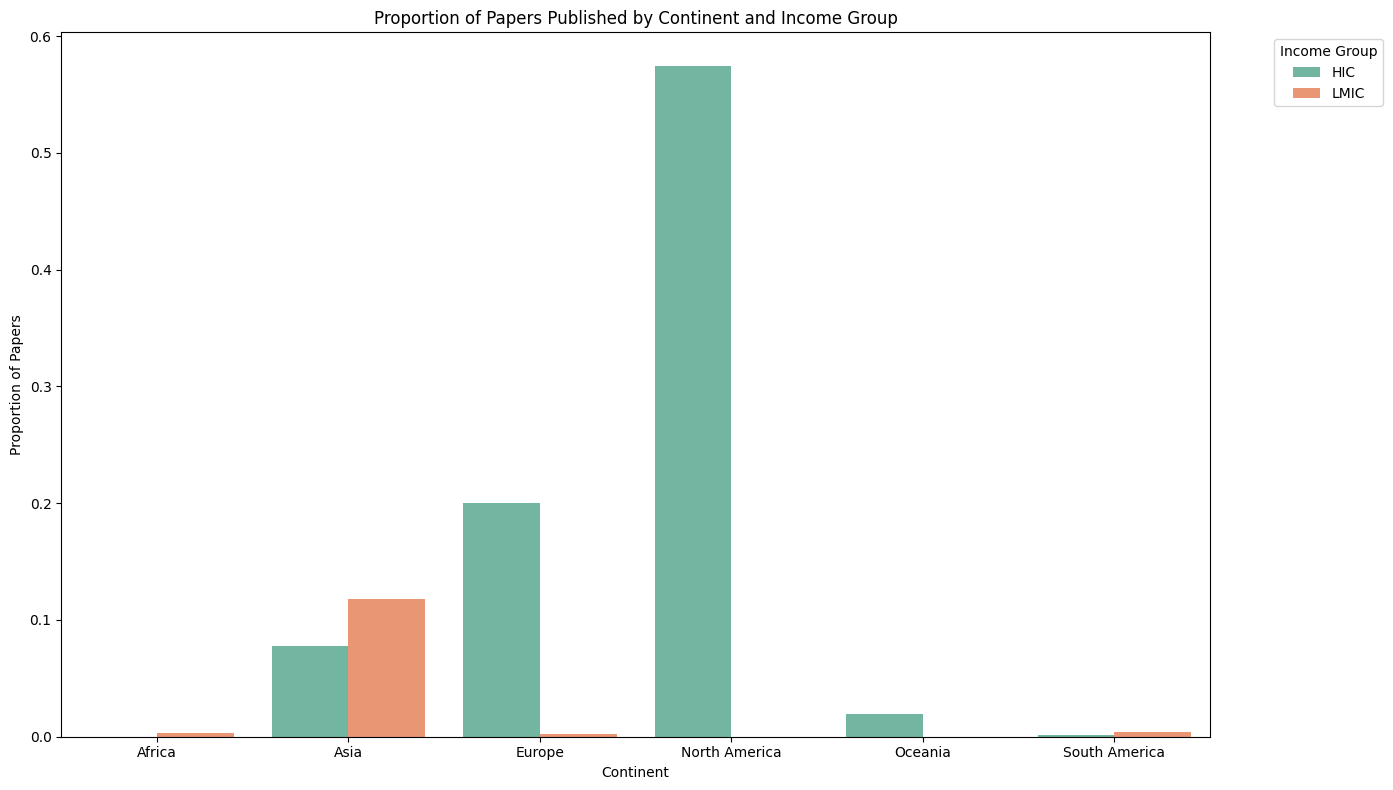

,continent,income_group,counts,proportion
0,Africa,LMIC,26,0.002875
1,Asia,HIC,703,0.077722
2,Asia,LMIC,1066,0.117855
3,Europe,HIC,1808,0.199889
4,Europe,LMIC,21,0.002322
5,North America,HIC,5197,0.574572
6,Oceania,HIC,176,0.019458
7,South America,HIC,10,0.001106
8,South America,LMIC,38,0.004201


In [21]:
# All authors
#plot_continent_papers(df, n_papers=100)
plot_continent_papers_probabilities(df, n_papers=100)

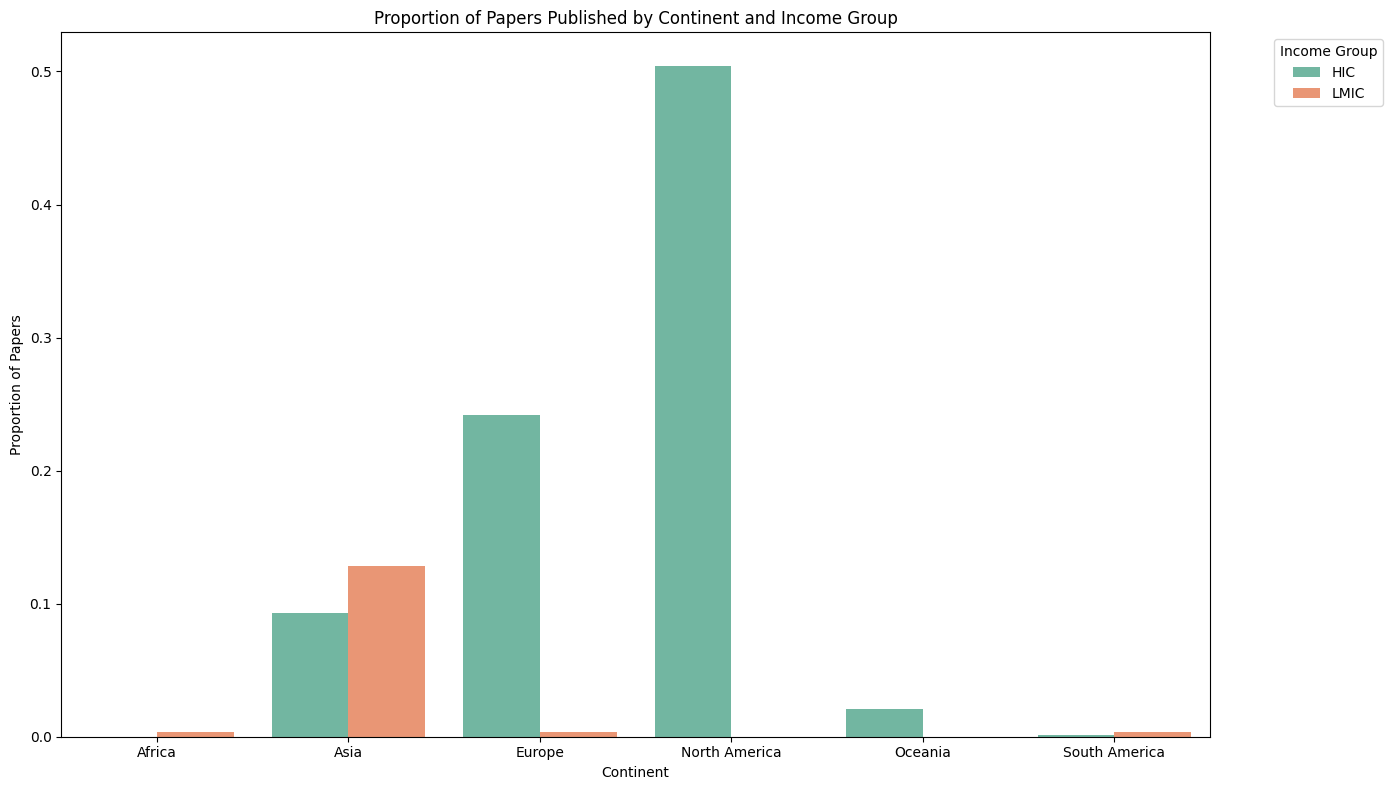

,continent,income_group,counts,proportion
0,Africa,LMIC,5,0.003511
1,Asia,HIC,132,0.092697
2,Asia,LMIC,183,0.128511
3,Europe,HIC,344,0.241573
4,Europe,LMIC,5,0.003511
5,North America,HIC,718,0.504213
6,Oceania,HIC,30,0.021067
7,South America,HIC,2,0.001404
8,South America,LMIC,5,0.003511


In [22]:
# First authors
#plot_continent_papers(df[df['is_first_author'] == True])
plot_continent_papers_probabilities(df[df['is_first_author'] == True])

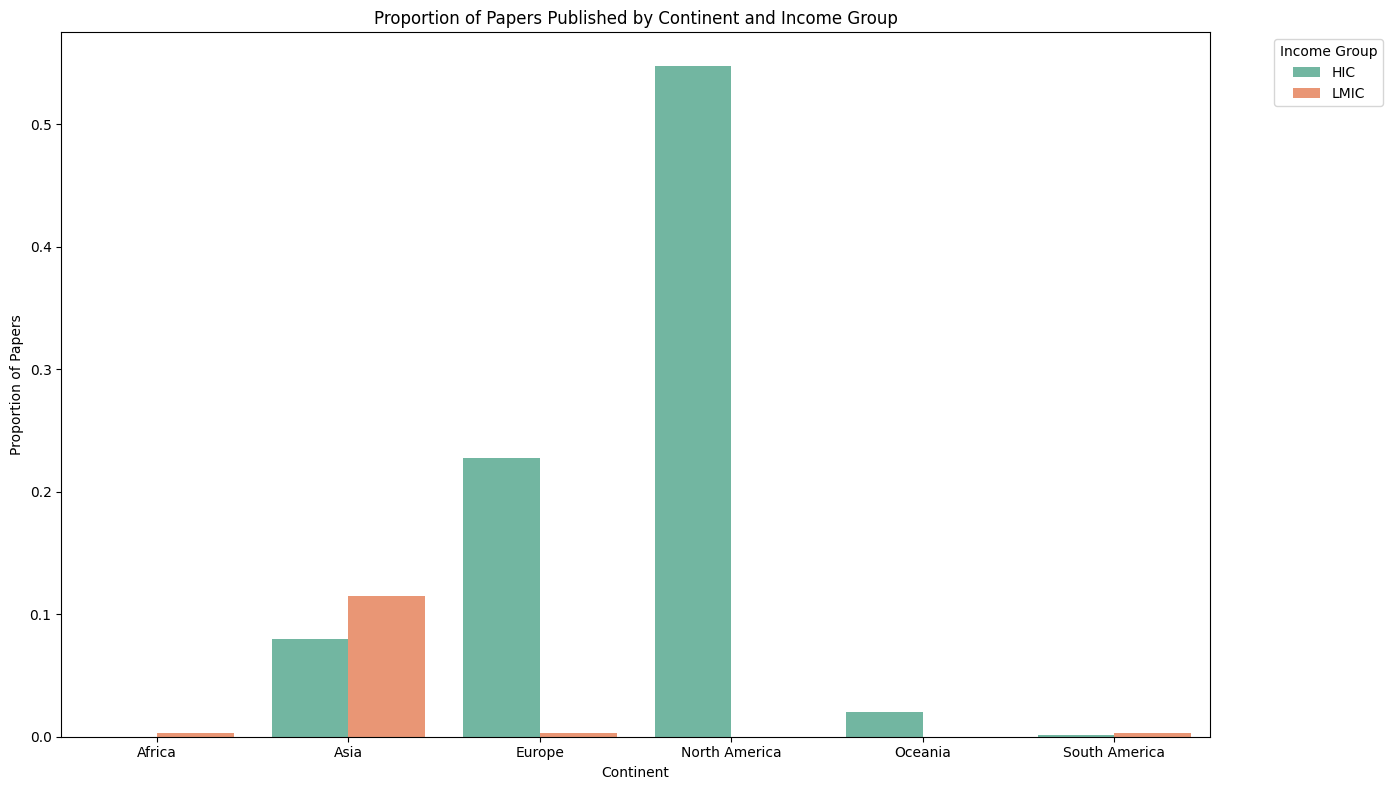

,continent,income_group,counts,proportion
0,Africa,LMIC,4,0.002714
1,Asia,HIC,118,0.080054
2,Asia,LMIC,169,0.114654
3,Europe,HIC,335,0.227273
4,Europe,LMIC,4,0.002714
5,North America,HIC,807,0.547490
6,Oceania,HIC,30,0.020353
7,South America,HIC,2,0.001357
8,South America,LMIC,5,0.003392


In [23]:
# Last authors
#plot_continent_papers(df[df['is_last_author'] == True])
plot_continent_papers_probabilities(df[df['is_last_author'] == True])

### Country distribution

### ALL

##### All Authors All countries

In [24]:
# Execute function
# top_15_countries = top_15_countries_per_journal_per_year(df)

##### Fisrt Authors All countries

In [25]:
### First authors:
# Execute function
# top_15_countries = top_15_countries_per_journal_per_year(df[df['is_first_author'] == True])

##### Last Authors All countries

In [26]:
### Last authors:
# Execute function
# top_15_countries = top_15_countries_per_journal_per_year(df[df['is_last_author'] == True])

### HICs

##### All authors HICs

In [27]:
# Execute function
# top_15_countries = top_15_countries_per_journal_per_year(hic_df, hic_country_codes)

##### First Authors HICs

In [28]:
# Execute function
# top_15_countries = top_15_countries_per_journal_per_year(hic_df[hic_df['is_first_author'] == True], hic_country_codes)

##### Last Authors HICs

In [29]:
# Execute function
# top_15_countries = top_15_countries_per_journal_per_year(hic_df[hic_df['is_last_author'] == True], hic_country_codes)

### LMICs

##### All authors LMICs

In [30]:
# Filter by only LMIC countries:
# top_15_countries = top_15_countries_per_journal_per_year(lmic_df, lmic_country_codes)
#top_15_countries = top_15_countries_per_journal_per_year(lmic_df) # Not filter only LMICs

##### First Authors LMICs

In [31]:
# Filter by only LMIC countries:
# top_15_countries = top_15_countries_per_journal_per_year(lmic_df[lmic_df['is_first_author'] == True], lmic_country_codes)

##### Last Authors LMICs

In [32]:
# Filter by only LMIC countries:
# top_15_countries = top_15_countries_per_journal_per_year(lmic_df[lmic_df['is_last_author'] == True], lmic_country_codes)

# Papers per journal

In [33]:
def papers_per_journal(df):
    # Group by doi to count unique papers
    unique_papers = df.drop_duplicates(subset='doi')

    # Count papers per journal per year
    papers_count = unique_papers.groupby(['journal_title']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

    return papers_count


In [34]:
def gender_probability_by_continent_and_income(df):
    continents = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
    income_groups = ['HIC', 'LMIC']
    genders = ['male', 'female']

    results = []

    # Iterate over each journal
    for journal in df['journal_title'].unique():
        journal_df = df[df['journal_title'] == journal]

        # Drop rows with unknown or NaN genders
        journal_df = journal_df[journal_df['gender'].isin(genders)]

        # Initialize a dictionary to store counts
        journal_counts = {'journal_title': journal}

        # Initialize total authors count for normalization
        total_authors_count = 0

        # Initialize counts for each combination
        for continent in continents:
            for income_group in income_groups:
                for gender in genders:
                    journal_counts[f'{continent}_{income_group}_{gender}'] = 0

        # Calculate counts for each gender, continent, and income group
        for _, row in journal_df.iterrows():
            for continent in continents:
                for income_group in income_groups:
                    if row[f'{continent}_{income_group}'] == 1:
                        total_authors_count += 1
                        if row['gender'] in genders:
                            journal_counts[f'{continent}_{income_group}_{row["gender"]}'] += 1

        # Calculate probabilities
        if total_authors_count > 0:
            for continent in continents:
                for income_group in income_groups:
                    for gender in genders:
                        journal_counts[f'{continent}_{income_group}_{gender}'] /= total_authors_count

        # Add the total authors count as support
        journal_counts['support'] = total_authors_count

        results.append(journal_counts)

    # Convert the results list to a DataFrame
    probabilities_df = pd.DataFrame(results)

    # Sort by support (number of authors) in descending order
    probabilities_df = probabilities_df.sort_values(by='support', ascending=False)
    probabilities_df = probabilities_df[probabilities_df['support'] > 0]

    return probabilities_df


Gini impurity ranges from 0 to 1.

0: Indicates a pure distribution where all elements belong to a single class. In this context, it would mean all authors from a journal come from the same gender, continent, and income group combination.

1: Indicates a highly impure distribution where the probabilities are evenly distributed across all classes.

In [35]:
def calculate_entropy(probabilities_df):
    entropy_results = []

    for _, row in probabilities_df.iterrows():
        probabilities = [row[col] for col in probabilities_df.columns if col.startswith('Africa') or col.startswith('Asia') or col.startswith('Europe') or col.startswith('North America') or col.startswith('Oceania') or col.startswith('South America')]
        probabilities = [p for p in probabilities if p > 0]  # Remove zero probabilities
        entropy = -np.sum(probabilities * np.log2(probabilities))
        entropy_results.append({'journal_title': row['journal_title'], 'entropy': entropy})

    return pd.DataFrame(entropy_results)


def gini_impurity(probabilities):
    """Calculate the Gini impurity for a list of probabilities."""
    return 1 - np.sum(np.square(probabilities))

def calculate_gini_impurity(probabilities_df):
    """Calculate the Gini impurity for each journal."""
    gini_results = []

    for _, row in probabilities_df.iterrows():
        probabilities = [row[col] for col in probabilities_df.columns if any(c in col for c in ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']) and pd.notna(row[col])]
        gini = gini_impurity(probabilities)
        gini_results.append({'journal_title': row['journal_title'], 'gini_impurity': gini})

    return pd.DataFrame(gini_results)

def plot_gini_impurity(gini_results_df):
    """Plot the Gini impurity for each journal, sorted by Gini impurity."""
    # Sort the DataFrame by Gini impurity
    sorted_gini_df = gini_results_df.sort_values(by='gini_impurity', ascending=False)

    # Plot
    plt.figure(figsize=(14, 8))
    sns.barplot(data=sorted_gini_df, x='journal_title', y='gini_impurity')
    plt.xticks(rotation=90)
    plt.title('Gini Impurity per Journal')
    plt.xlabel('Journal Title')
    plt.ylabel('Gini Impurity')
    plt.tight_layout()
    plt.show()



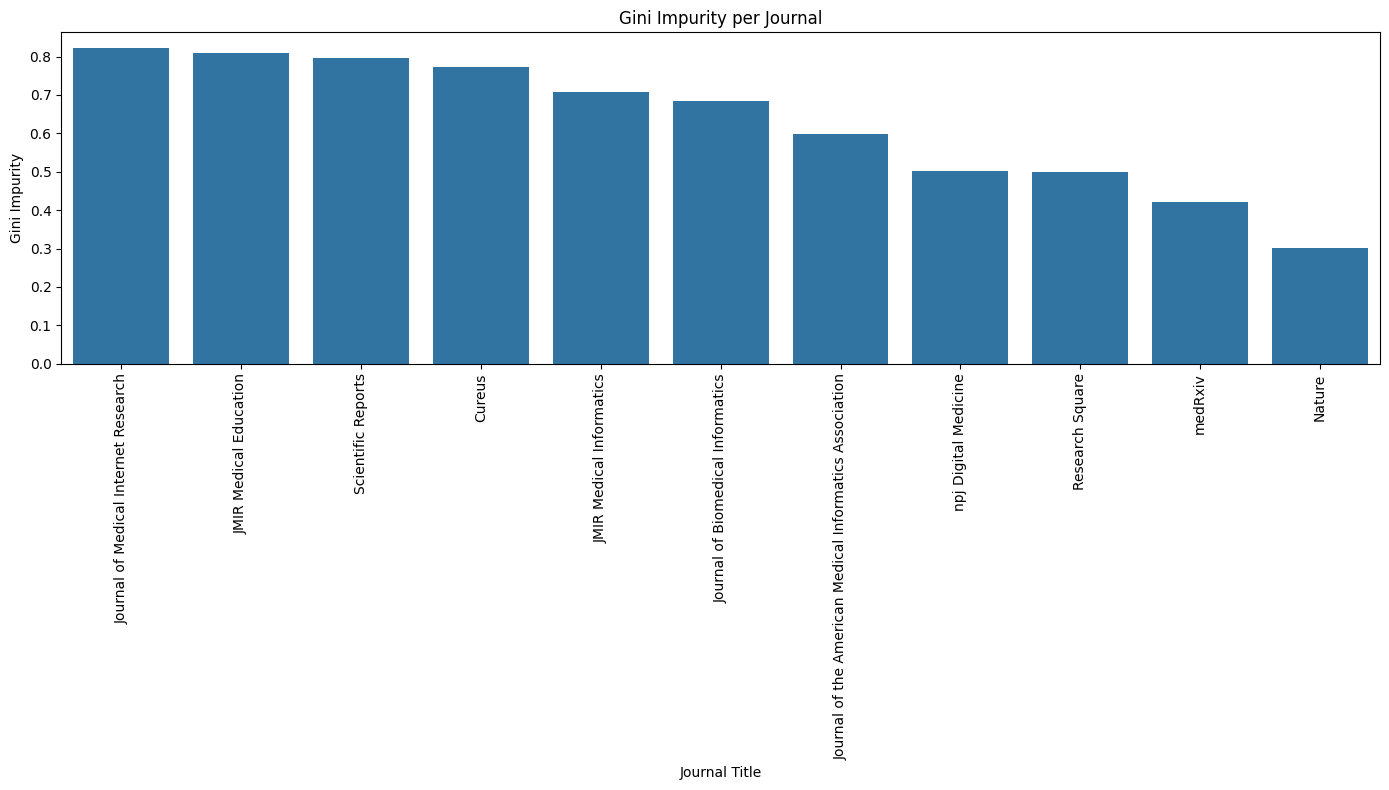

,journal_title,Africa_HIC_male,Africa_HIC_female,Africa_LMIC_male,Africa_LMIC_female,Asia_HIC_male,Asia_HIC_female,Asia_LMIC_male,Asia_LMIC_female,Europe_HIC_male,...,Oceania_HIC_male,Oceania_HIC_female,Oceania_LMIC_male,Oceania_LMIC_female,South America_HIC_male,South America_HIC_female,South America_LMIC_male,South America_LMIC_female,support,gini_impurity
8,Nature,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,113,0.302608
0,medRxiv,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.003578,0.000000,0.008945,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,559,0.421856
10,Research Square,0.0,0.0,0.000000,0.000000,0.009804,0.000000,0.000000,0.000000,0.029412,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.019608,0.0,102,0.499039
2,npj Digital Medicine,0.0,0.0,0.000000,0.000000,0.004444,0.000000,0.040000,0.008889,0.035556,...,0.000000,0.000000,0.0,0.0,0.004444,0.0,0.000000,0.0,225,0.502400
1,Journal of the American Medical Informatics As...,0.0,0.0,0.000000,0.000000,0.077966,0.013559,0.071186,0.023729,0.033898,...,0.006780,0.003390,0.0,0.0,0.000000,0.0,0.003390,0.0,295,0.597415
5,Journal of Biomedical Informatics,0.0,0.0,0.005025,0.000000,0.005025,0.010050,0.120603,0.035176,0.135678,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,199,0.685235
9,JMIR Medical Informatics,0.0,0.0,0.000000,0.000000,0.186275,0.009804,0.068627,0.039216,0.078431,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,102,0.707805
3,Cureus,0.0,0.0,0.004545,0.000000,0.209091,0.009091,0.231818,0.113636,0.022727,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,220,0.771736
7,Scientific Reports,0.0,0.0,0.016807,0.008403,0.058824,0.016807,0.235294,0.050420,0.352941,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,119,0.795142
4,JMIR Medical Education,0.0,0.0,0.000000,0.000000,0.155963,0.036697,0.073394,0.022936,0.211009,...,0.000000,0.032110,0.0,0.0,0.000000,0.0,0.022936,0.0,218,0.808770


In [36]:
probabilities = gender_probability_by_continent_and_income(df)

# filter support
support = 100
probabilities = probabilities[probabilities['support'] > support]

# Example usage
# probabilities_df = gender_probability_by_continent_and_income(df)
gini_results_df = calculate_gini_impurity(probabilities)

# Sort
probabilities = probabilities.merge(gini_results_df, on='journal_title').sort_values(by='gini_impurity', ascending=True)

plot_gini_impurity(gini_results_df)

probabilities

# Top Funding Countries

In [37]:
def top_n_funder_countries(df, n=10, n_papers=20):
    # Group by doi to count unique papers
    unique_papers = df.drop_duplicates(subset='doi')

    # Group by journal_title, year, and funder_country, then count occurrences
    funder_counts = unique_papers.groupby(['journal_title', 'year', 'funder_country']).size().reset_index(name='counts')

    # Generate plots per journal and then per year within each journal
    for journal in funder_counts['journal_title'].unique():
        journal_data = funder_counts[funder_counts['journal_title'] == journal]

        papers_journal = unique_papers[unique_papers['journal_title'] == journal]['doi'].nunique()

        if papers_journal < n_papers:
            #print(f'Journal {journal} has less than {n_papers} papers ({n_papers}), so it will not be plotted.')
            continue

        # Get the top n funder countries per year within the journal
        top_n_per_year = journal_data.groupby('year').apply(lambda x: x.nlargest(n, 'counts')).reset_index(drop=True)
        print(top_n_per_year)

        # Plot the journal data for all years
        plt.figure(figsize=(14, 8))
        sns.barplot(data=top_n_per_year, x='year', y='counts', hue='funder_country', ci=None)
        plt.title(f'Top {n} funder Countries Published in {journal}')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # Plot the journal data for all years (by country)
        country_order = top_n_per_year.groupby('funder_country')['counts'].sum().sort_values(ascending=False).index.tolist()
        plt.figure(figsize=(14, 8))
        sns.barplot(data=top_n_per_year, x='funder_country', y='counts', order=country_order)
        plt.title(f'Top {n} funder Countries Published in {journal} over all years')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Generate individual plots per year within each journal
        #for year in top_n_per_year['year'].unique():
        #    year_data = top_n_per_year[top_n_per_year['year'] == year]
        #    plt.figure(figsize=(14, 8))
        #    sns.barplot(data=year_data, x='funder_country', y='counts')
        #    plt.title(f'Top {n} funder Countries Published in {journal} in {year}')
        #    plt.xticks(rotation=45)
        #    plt.tight_layout()
        #    plt.show()

    return top_n_per_year

In [38]:
def plot_continent_funders(df, n_papers=300):
    continents = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
    income_groups = ['HIC', 'LMIC']

    unique_papers = df.drop_duplicates(subset='doi')

    # Melt the dataframe to aggregate by continent and income group
    melted_df = pd.melt(unique_papers, id_vars=['journal_title', 'year', 'id'],
                        value_vars=[f'{continent}_{income_group}_funder' for continent in continents for income_group in income_groups],
                        var_name='continent_income_funder', value_name='count')

    # Filter out rows where count is 0
    melted_df = melted_df[melted_df['count'] == 1]

    # Split 'continent_income_funder' into 'continent' and 'income_group'
    melted_df[['continent', 'income_group']] = melted_df['continent_income_funder'].str.rsplit('_', n=2, expand=True).iloc[:, :2]

    # Group by continent and income group to count occurrences
    continent_counts = melted_df.groupby(['continent', 'income_group']).size().reset_index(name='counts')

    # Plot the data
    plt.figure(figsize=(14, 8))
    sns.barplot(data=continent_counts, x='continent', y='counts', hue='income_group', palette="Set2", errorbar="sd", hue_order=income_groups)
    plt.title('Number of Funders by Continent and Income Group')
    plt.xlabel('Continent')
    plt.ylabel('Number of Funders')
    plt.legend(title='Income Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Count the number of unique papers per journal
    journal_paper_counts = unique_papers.groupby('journal_title')['doi'].nunique()

    # Filter journals with more than n_papers
    qualifying_journals = journal_paper_counts[journal_paper_counts > n_papers].index

    # Plot by journal for qualifying journals
    for journal in qualifying_journals:
        journal_df = melted_df[melted_df['journal_title'] == journal]

        # Group by continent and income group to count occurrences
        journal_continent_counts = journal_df.groupby(['continent', 'income_group']).size().reset_index(name='counts')

        # Plot the data for the journal
        plt.figure(figsize=(14, 8))
        sns.barplot(data=journal_continent_counts, x='continent', y='counts', hue='income_group', palette="Set2", errorbar="sd", hue_order=income_groups)
        plt.title(f'Number of Funders by Continent and Income Group in {journal}')
        plt.xlabel('Continent')
        plt.ylabel('Number of Funders')
        plt.legend(title='Income Group', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    return continent_counts

In [39]:

def plot_continent_funders_probabilities(df, n_papers=300):
    continents = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
    income_groups = ['HIC', 'LMIC']

    # Ensure each DOI is unique
    unique_papers = df.drop_duplicates(subset='doi')

    # Melt the dataframe to aggregate by continent and income group
    melted_df = pd.melt(unique_papers, id_vars=['journal_title', 'year', 'id', 'doi'],
                        value_vars=[f'{continent}_{income_group}_funder' for continent in continents for income_group in income_groups],
                        var_name='continent_income_funder', value_name='count')

    # Filter out rows where count is 0
    melted_df = melted_df[melted_df['count'] == 1]

    # Split 'continent_income_funder' into 'continent' and 'income_group'
    melted_df[['continent', 'income_group']] = melted_df['continent_income_funder'].str.rsplit('_', n=2, expand=True).iloc[:, :2]

    # Group by continent and income group to count occurrences
    continent_counts = melted_df.groupby(['continent', 'income_group']).size().reset_index(name='counts')

    # Filter out NaN values for calculating proportions
    continent_counts = continent_counts.dropna()

    # Calculate the total counts to get proportions
    total_counts = continent_counts['counts'].sum()
    continent_counts['proportion'] = continent_counts['counts'] / total_counts

    # Plot the data
    plt.figure(figsize=(14, 8))
    sns.barplot(data=continent_counts, x='continent', y='proportion', hue='income_group', palette="Set2", hue_order=income_groups)
    plt.title('Proportion of Funders by Continent and Income Group')
    plt.xlabel('Continent')
    plt.ylabel('Proportion of Funders')
    plt.legend(title='Income Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Count the number of unique papers per journal
    journal_paper_counts = unique_papers.groupby('journal_title')['doi'].nunique()

    # Filter journals with more than n_papers
    qualifying_journals = journal_paper_counts[journal_paper_counts > n_papers].index

    # Plot by journal for qualifying journals
    for journal in qualifying_journals:
        journal_df = melted_df[melted_df['journal_title'] == journal]

        # Group by continent and income group to count occurrences
        journal_continent_counts = journal_df.groupby(['continent', 'income_group']).size().reset_index(name='counts')

        # Filter out NaN values for calculating proportions
        journal_continent_counts = journal_continent_counts.dropna()

        # Calculate the total counts to get proportions
        total_journal_counts = journal_continent_counts['counts'].sum()
        journal_continent_counts['proportion'] = journal_continent_counts['counts'] / total_journal_counts

        # Plot the data for the journal
        plt.figure(figsize=(14, 8))
        sns.barplot(data=journal_continent_counts, x='continent', y='proportion', hue='income_group', palette="Set2", hue_order=income_groups)
        plt.title(f'Proportion of Funders by Continent and Income Group in {journal}')
        plt.xlabel('Continent')
        plt.ylabel('Proportion of Funders')
        plt.legend(title='Income Group', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    return continent_counts

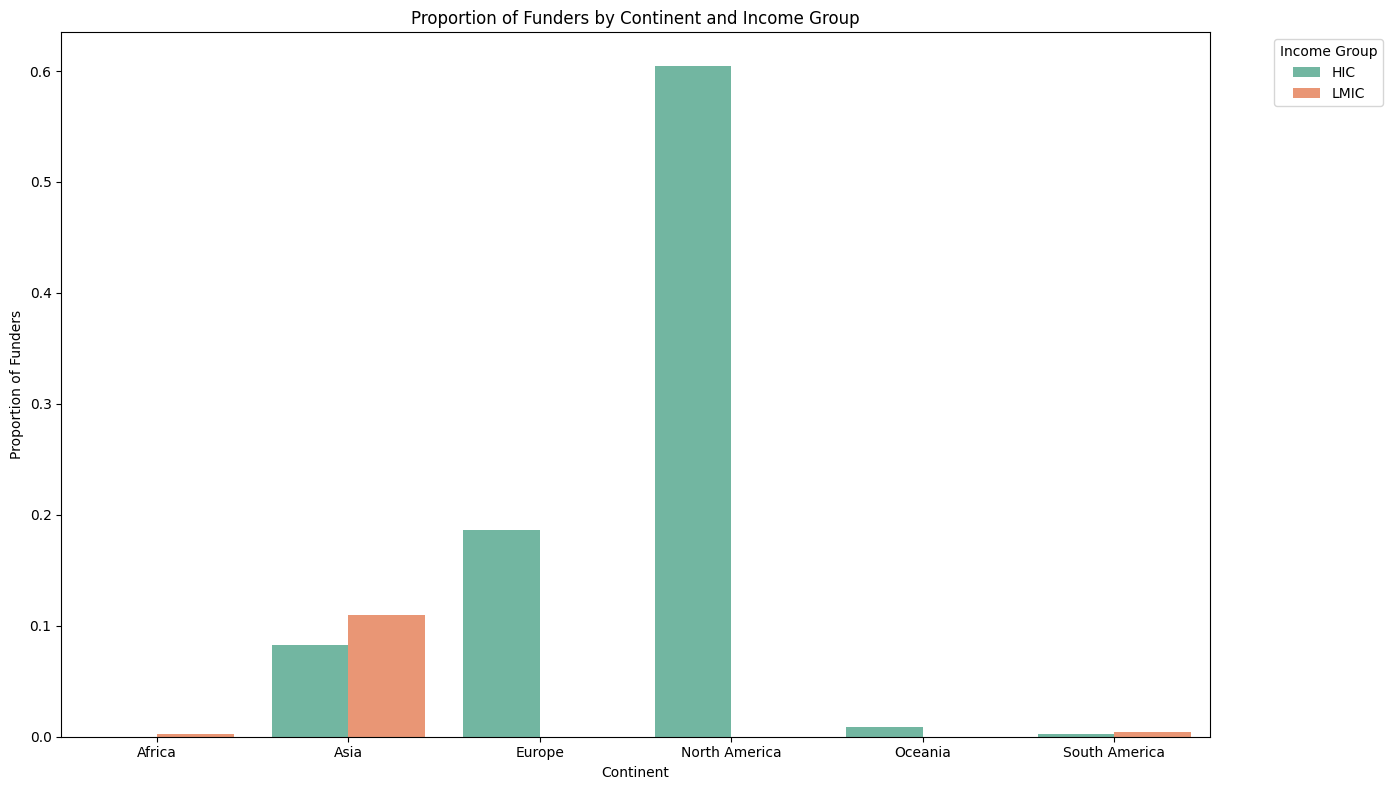

,continent,income_group,counts,proportion
0,Africa,LMIC,1,0.002114
1,Asia,HIC,39,0.082452
2,Asia,LMIC,52,0.109937
3,Europe,HIC,88,0.186047
4,North America,HIC,286,0.604651
5,Oceania,HIC,4,0.008457
6,South America,HIC,1,0.002114
7,South America,LMIC,2,0.004228


In [40]:
#plot_continent_funders(df)
plot_continent_funders_probabilities(df)

### ALL

##### All Authors All countries

In [41]:
# Execute function
#top_n_funders = top_n_funder_countries(df, n_papers=20)

### HICs

##### All authors HICs

In [42]:
# Execute function
#top_n_funders = top_n_funder_countries(hic_df, n=10)

### LMICs

##### All authors LMICs

In [43]:
# Execute function
#top_n_funders = top_n_funder_countries(lmic_df, n=10)

### Heat Map Countries Per Journal Per Year

In [54]:
def author_countries_heatmap(df, list_countries=None, n_papers=300):
    # Melt the dataframe to count countries from first_country, second_country, third_country
    countries_df = df.melt(id_vars=['journal_title', 'year'], value_vars=['first_country', 'second_country', 'third_country'],
                           var_name='country_type', value_name='country')

    country_codes_df = df.melt(id_vars=['journal_title', 'year'],
                            value_vars=['first_country_code', 'second_country_code', 'third_country_code'],
                            var_name='country_code_type', value_name='country_code_aux')

    # Merge the two melted DataFrames on the index
    countries_df['country_code'] = country_codes_df['country_code_aux']

    # Group by journal and year, then count the occurrences of each country
    if list_countries:
        countries_df = countries_df[countries_df['country_code'].isin(list_countries)]
    # Filter out rows with invalid country codes
    countries_df = countries_df[countries_df['country'].notna()]

    # Convert country names to ISO alpha-3 codes
    countries_df['country_code'] = countries_df['country'].apply(country_to_alpha_3)


    # Load the world map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Group by year and country_code, then count occurrences
    country_year_counts = countries_df.groupby(['year', 'country_code']).size().reset_index(name='counts')

    # Merge with world map using country codes
    world = world.rename(columns={'iso_a3': 'country_code'})

    world_counts = world.merge(country_year_counts, on='country_code', how='left').fillna(0)

    # Plot heatmap for countries for all years and all journals
    country_counts_all_years = countries_df.groupby('country_code').size().reset_index(name='counts')
    world_counts_all_years = world.merge(country_counts_all_years, on='country_code', how='left').fillna(0)
    plt.figure(figsize=(14, 8))
    ax = plt.gca()
    world.boundary.plot(ax=ax, linewidth=1)
    if world_counts_all_years['counts'].sum() > 0:
        world_counts_all_years.plot(column='counts', cmap='YlGnBu', legend=True, ax=ax,
                                    legend_kwds={'label': "Number of Publications"})
        plt.title('Author Countries Publishing in All Journals (All Years)')
        plt.show()
    else:
        plt.close()

    # Plot heatmap for countries per year
    #for year in country_year_counts['year'].unique():
    #    plt.figure(figsize=(14, 8))
    #    ax = plt.gca()
    #    world.boundary.plot(ax=ax, linewidth=1)
    #    year_data = world_counts[world_counts['year'] == year]
    #    if year_data['counts'].sum() > 0:
    #        year_data.plot(column='counts', cmap='YlGnBu', legend=True, ax=ax, legend_kwds={'label': "Number of Publications"})
    #        plt.title(f'Author Countries Publishing in {year}')
    #        plt.show()
    #    else:
    #        plt.close()

    # Group by journal_title, year, and country_code, then count occurrences
    country_journal_year_counts = countries_df.groupby(['journal_title', 'year', 'country_code']).size().reset_index(name='counts')

    # Merge with world map using country codes
    world_journal_counts = world.merge(country_journal_year_counts, on='country_code', how='left').fillna(0)

    # Plot heatmap for countries per journal per year
    for journal in country_journal_year_counts['journal_title'].unique():
        journal_data = world_journal_counts[world_journal_counts['journal_title'] == journal]
        n_papers_journal = df[df['journal_title'] == journal]['doi'].nunique()
        if n_papers_journal < n_papers:
            #print(f'Journal {journal} has less than {n_papers} papers ({n_papers_journal}), so it will not be plotted.')
            continue
        if journal_data['counts'].sum() > 0:
            plt.figure(figsize=(14, 8))
            ax = plt.gca()
            world.boundary.plot(ax=ax, linewidth=1)
            journal_data.plot(column='counts', cmap='YlGnBu', legend=True, ax=ax, legend_kwds={'label': "Number of Publications"})
            plt.title(f'Author Countries Publishing in {journal} during 2018 and 2023')
            plt.show()
        else:
            plt.close()

        #for year in country_journal_year_counts['year'].unique():
        #    #journal_year_data = world_journal_counts[(world_journal_counts['journal_title'] == journal) &
        #    #                                         (world_journal_counts['year'] == year)]
        #    journal_year_data = journal_data[journal_data['year'] == year]
        #
        #    if journal_year_data['counts'].sum() > 0:
        #        plt.figure(figsize=(14, 8))
        #        ax = plt.gca()
        #        world.boundary.plot(ax=ax, linewidth=1)
        #        journal_year_data.plot(column='counts', cmap='YlGnBu', legend=True, ax=ax, legend_kwds={'label': "Number of Publications"})
        #        plt.title(f'Author Countries Publishing in {journal} in {year}')
        #        plt.show()
        #    else:
        #        plt.close()


### ALL

##### All Authors All countries

<ipython-input-54-2515fa8dd4cc>:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


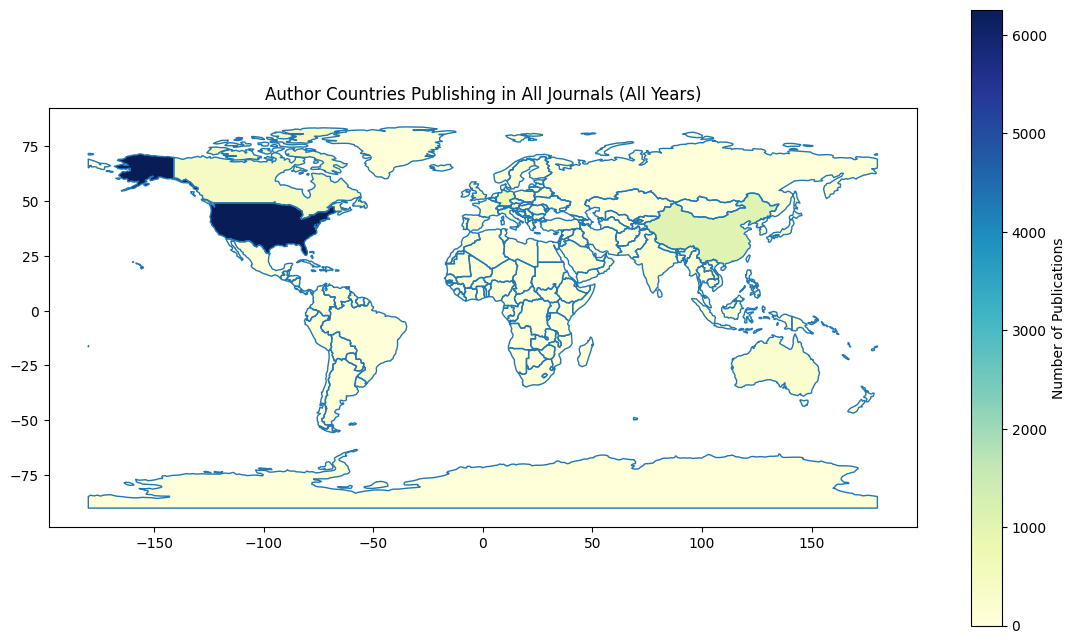

In [55]:
# Execute function
author_countries_heatmap(df)

##### First Authors All countries

<ipython-input-54-2515fa8dd4cc>:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


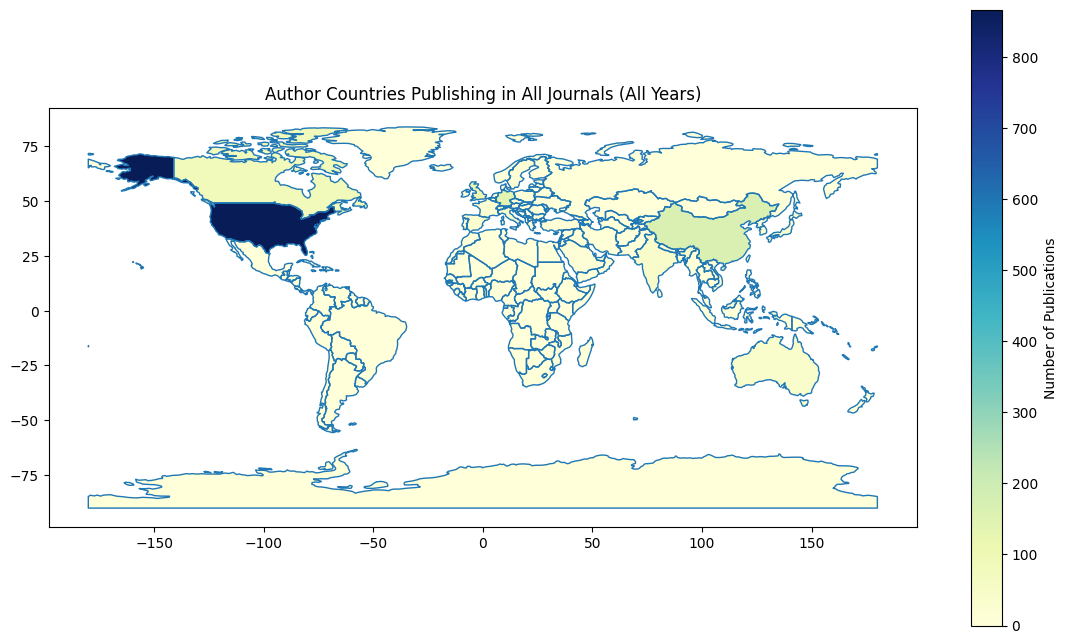

In [56]:
author_countries_heatmap(df[df['is_first_author'] == True])

##### Last Authors All countries

<ipython-input-54-2515fa8dd4cc>:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


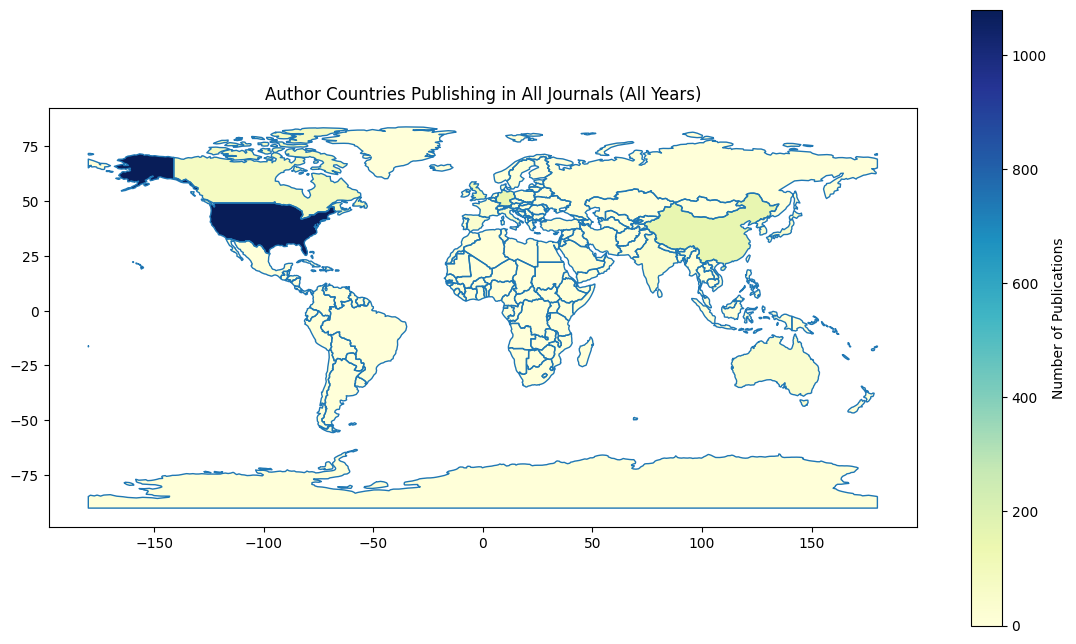

In [57]:
author_countries_heatmap(df[df['is_last_author'] == True])

### HICs

##### All authors HICs

<ipython-input-54-2515fa8dd4cc>:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


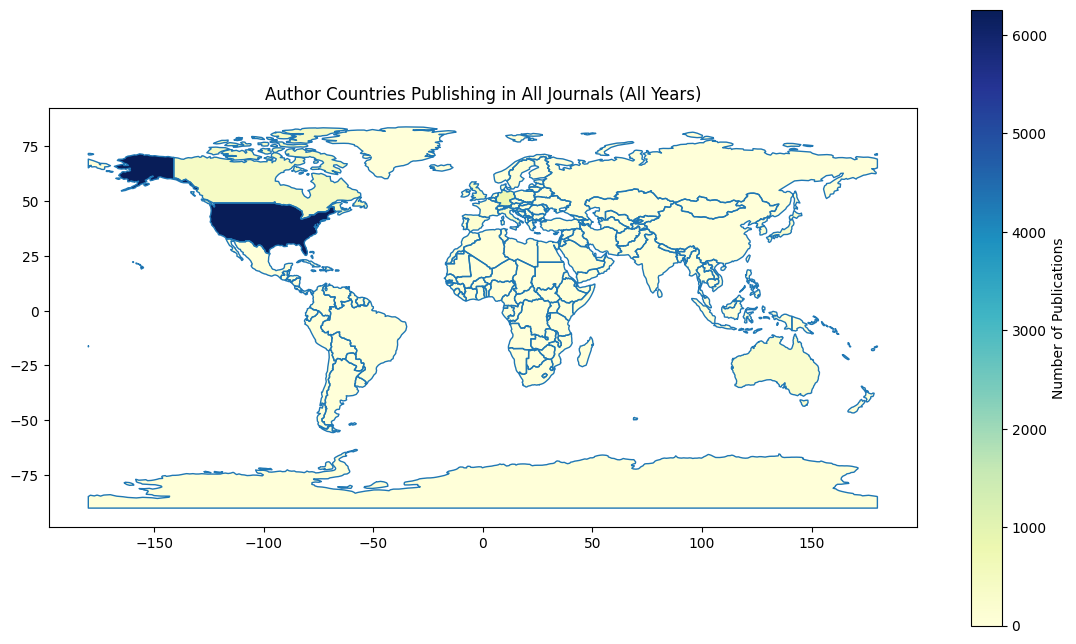

In [58]:
# Execute function
author_countries_heatmap(hic_df, hic_country_codes)

##### First Authors HICs

<ipython-input-54-2515fa8dd4cc>:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


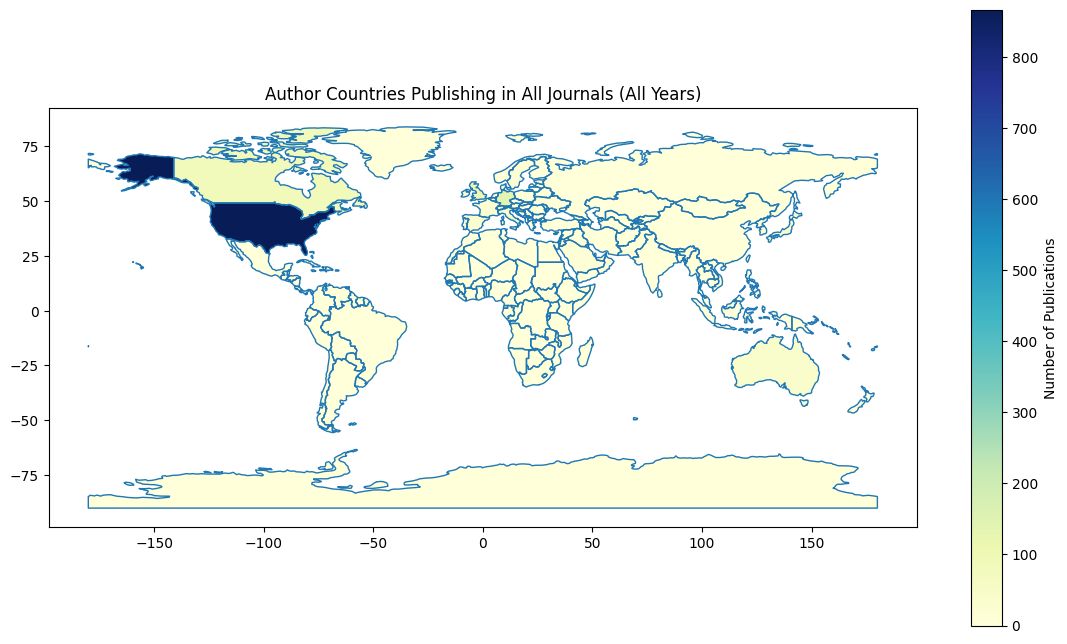

In [59]:
author_countries_heatmap(hic_df[hic_df['is_first_author'] == True], hic_country_codes)

##### Last Authors HICs

<ipython-input-54-2515fa8dd4cc>:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


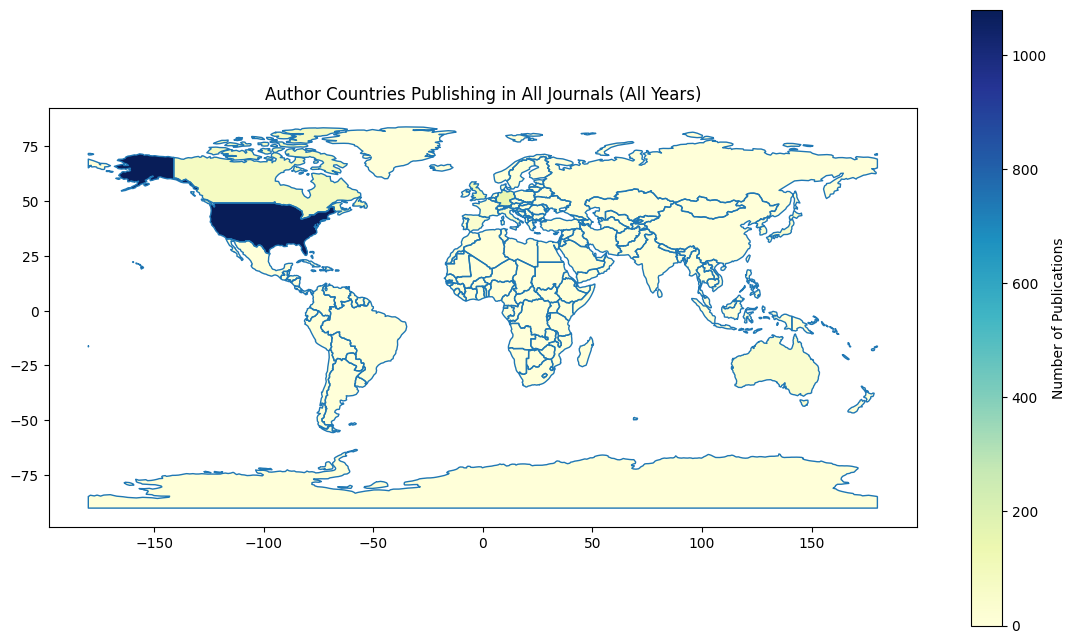

In [60]:
author_countries_heatmap(hic_df[hic_df['is_last_author'] == True], hic_country_codes)

### LMICs

##### All authors LMICs

<ipython-input-54-2515fa8dd4cc>:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


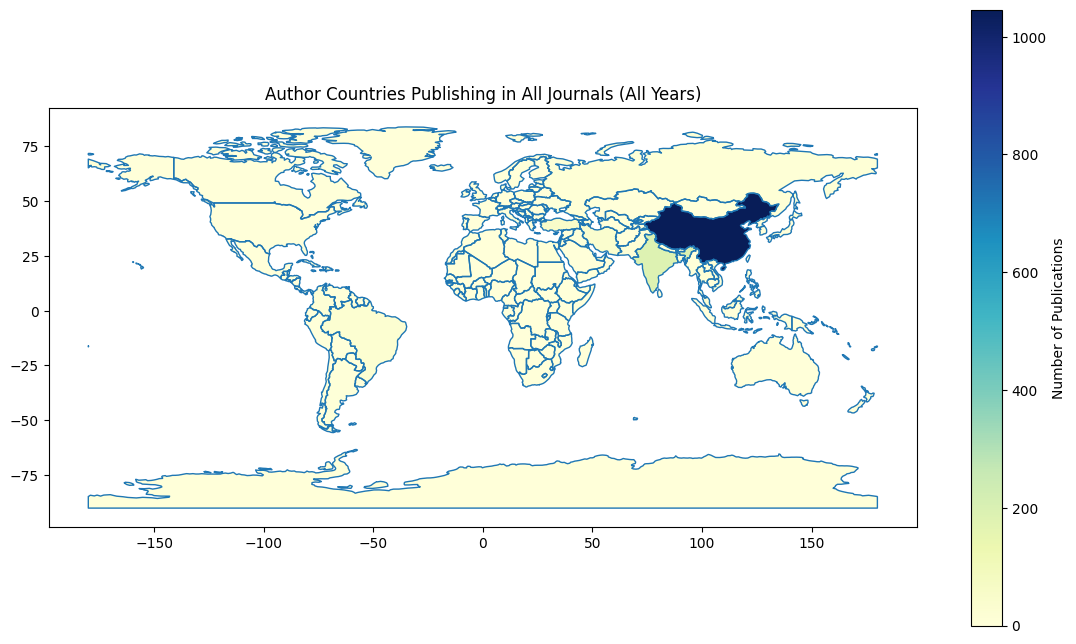

In [61]:
# Execute function
author_countries_heatmap(lmic_df, lmic_country_codes)

##### First Authors LMICs

<ipython-input-54-2515fa8dd4cc>:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


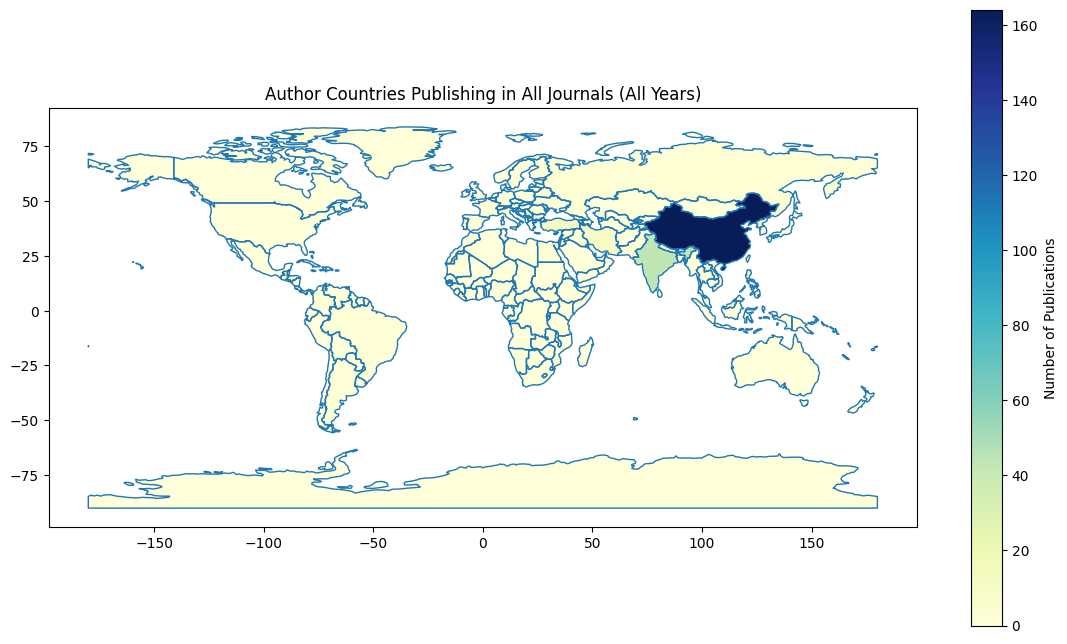

In [62]:
author_countries_heatmap(lmic_df[lmic_df['is_first_author'] == True], lmic_country_codes)

##### Last Authors LMICs

<ipython-input-54-2515fa8dd4cc>:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


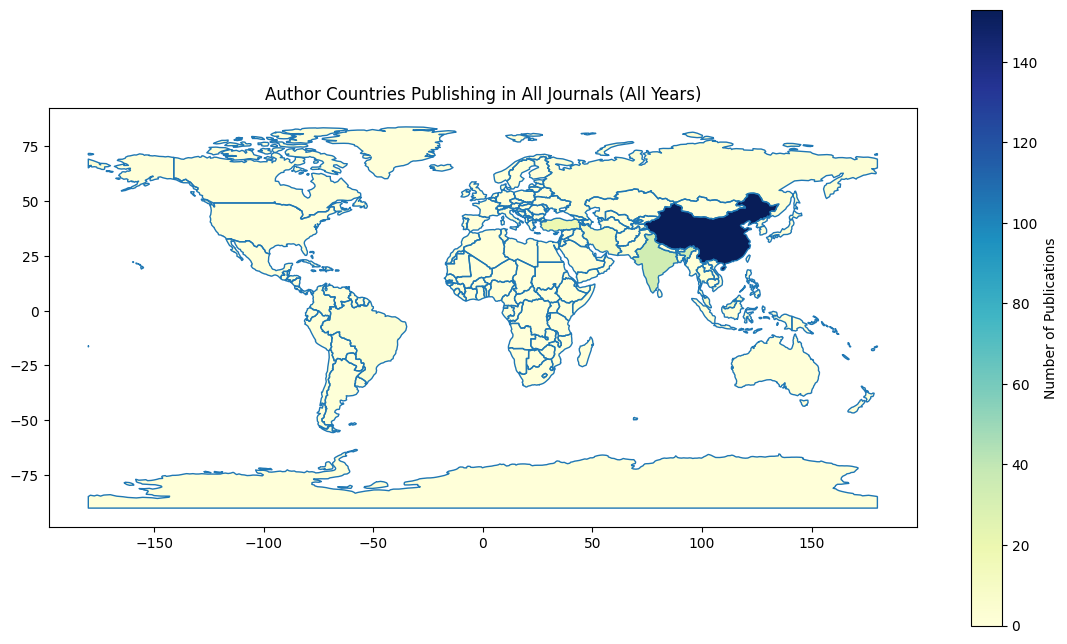

In [63]:
author_countries_heatmap(lmic_df[lmic_df['is_last_author'] == True], lmic_country_codes)